In [1]:
from pricing import EquityForwardCurve, DiscountingCurve, Black, ForwardVariance, Vanilla_PayOff
import numpy as np
import matplotlib.pyplot as plt
from scipy import log, sqrt, exp
from closedforms import European_closed_form
from montecarlo import MC
import lets_be_rational.LetsBeRational as lbr
import openpyxl

In [2]:
r = 1/100
volatility = 20/100
spot_price = 180
number_dates = 10
expiry = 10
K =150

In [3]:
T = np.array([1.,2.,3.])/12
K = np.array([172,180])
sigma = np.array(([21.2,20.5,19.4],[30,25,26]))
sigma = sigma/100

In [4]:
#the implied volatility data for NVIDIA as of 31 January 2014
T = np.array([0.08,0.17,0.25,0.33,0.42,0.50,1.0,2.0,3.0])
K = np.array([157,164,172,180])
sigma = np.array(([32.2,29.3,29.1,29.5,29.7,29.8,29.9,30.6,30.62],[32,29.1,28.9,29.3,29.4,29.4,29.6,30.6,30.63],[33.6,29.3,29,29.3,29.3,29.3,29.3,30.6,30.59],[35,29.7,29.4,29.5,29.4,29.3,29.3,30.5,30.46]))
sigma = sigma/100

In [5]:
vol = ForwardVariance(reference=0,maturities=T,strikes=K,spot_volatility=sigma,strike_interp=spot_price)

[0.35       0.24026675 0.28752109 0.29810338 0.29030386 0.28769298
 0.293      0.31654542 0.30379842]


In [6]:
vol(2)

0.09229347999999997

In [7]:
from scipy.integrate import quad
i = 5
np.random.seed(10)
Z = np.random.normal(0,1,10)
logmartingale = -0.5*quad(vol,T[i-1],T[i])[0]+sqrt(quad(vol,T[i-1],T[i])[0])*Z
#logmartingale= -0.5*quad(vol,0,T[i])[0]+sqrt(quad(vol,0,T[i])[0])*Z  
logmartingale

array([ 0.10504298,  0.05489289, -0.12906279, -0.0039929 ,  0.04724858,
       -0.06190539,  0.01829448,  0.00552211, -0.00296149, -0.01751823])

In [8]:
np.random.seed(10)
Z = np.random.normal(0,1,10)
logmartingale = -0.5* (vol(T[i]))*(T[i]-T[i-1]) + sqrt((vol(T[i]))*(T[i]-T[i-1]))*Z
logmartingale

array([ 0.10691849,  0.05584329, -0.13150579, -0.00412875,  0.04805796,
       -0.06310955,  0.01856976,  0.00556177, -0.00307832, -0.01790359])

[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


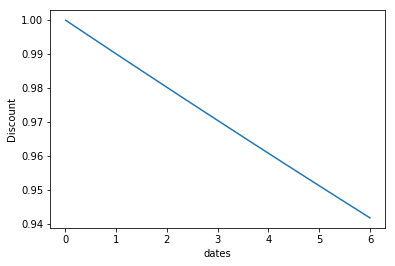

In [9]:
"""I want to create a discounting costant curve such that r = 1/100"""
dates = np.linspace(0.001,expiry,number_dates)
r = np.ones(number_dates)*r
d = exp(-r*dates)
D = DiscountingCurve(reference=0, discounts=d, dates=dates)
x = np.linspace(0.006,6,100)
plt.plot(x,D(x))
plt.xlabel("dates")
plt.ylabel("Discount")
plt.show()

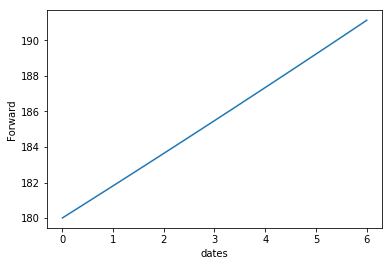

In [10]:
"""Create a Forward Curve with 0 repo_zero_rate"""
F = EquityForwardCurve(reference=0,spot=spot_price,discounting_curve=D,repo_rates=[0,0],repo_dates=[0,expiry])
plt.plot(x,F(x))
plt.xlabel("dates")
plt.ylabel("Forward")
plt.show()

### Generation of the implied volatility surface

In [11]:
BS = Black(forward_curve=F,variance=vol)

In [12]:
T = np.array([0.08,0.17,0.25,0.33,0.42,0.50,1.0,2.0,3.0])
S_t = BS.simulate(Nsim=1e6,fixings=T)
kind = 1

In [13]:
X_t = S_t/F(T)
pay = Vanilla_PayOff(St=X_t, strike=spot_price/F(T), typo=kind)
result,err = MC(pay)

In [14]:
E = np.mean(X_t,axis=0)
n = 3
i = n-1
lbr.implied_volatility_from_a_transformed_rational_guess(result[i],E[i],spot_price/F(T[i]),T[i],kind)# , sigma.T[1][3]

0.29362001948548927

In [15]:
imp_volatility = np.zeros(len(T))
imp_volatility_plus = np.zeros(len(T))
imp_volatility_minus = np.zeros(len(T))
for i in range (len(T)):
    imp_volatility[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i],E[i],spot_price/F(T[i]),T[i],kind)
    imp_volatility_minus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]-err[i],E[i],spot_price/F(T[i]),T[i],kind)
    imp_volatility_plus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]+err[i],E[i],spot_price/F(T[i]),T[i],kind)

In [16]:
y_lower = np.zeros(len(T))
y_upper =np.zeros(len(T))
for i in range(len(T)):
    if(imp_volatility_minus[i]<imp_volatility_plus[i]):
        y_lower[i]= abs(imp_volatility[i]-imp_volatility_minus[i])
        y_upper[i]= abs(imp_volatility_plus[i]-imp_volatility[i])
    elif(imp_volatility_minus[i]>imp_volatility_plus[i]):
        y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_plus[i])
        y_upper[i][j] = abs(imp_volatility_minus[i]-imp_volatility[i])

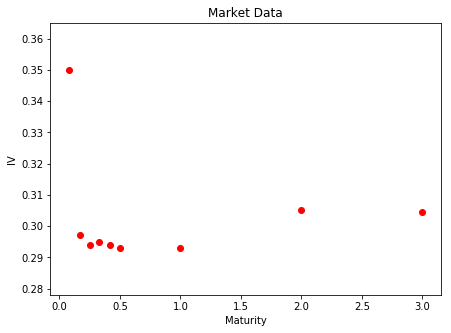

In [17]:
#plt.errorbar(T,imp_volatility,yerr=[2*y_lower,2*y_upper], fmt = "o", label = "Monte Carlo")
plt.figure(figsize=(7,5))
plt.scatter(T,sigma[len(sigma)-1],color="Red")
plt.title("Market Data")
plt.xlabel("Maturity")
plt.ylabel("IV")
plt.savefig("market_data.pdf")
#plt.legend()
plt.show()

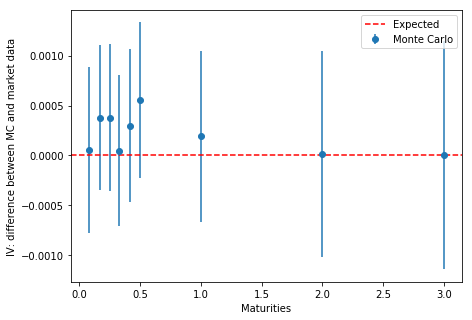

In [18]:
plt.figure(figsize=(7,5))
plt.errorbar(T,abs(imp_volatility-sigma[len(sigma)-1]),yerr=[2*y_lower,2*y_upper], fmt = "o", label = "Monte Carlo")
plt.axhline(y=0, color = 'red',linestyle='--',label = 'Expected')
plt.xlabel("Maturities")
plt.ylabel("IV: difference between MC and market data")
plt.legend()
plt.savefig("Monte_carlo_sigma_time_dep.pdf")
plt.show()